In [1]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')
import seaborn as sns

import string
import time
import threading
import os.path
import nltk


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sklearn.cluster import SpectralClustering


import mapping_funnction as MF

# Text processing
Here removal of punctuation, stopwords, digit and lemmatization function are defined

In [2]:
def process_text(phrase):
    """
    This function remove punctuation and stopwords
    """
    
    def Refinement_Phrase(PhraseList):
        """
        This nested function takes away all words that are unecessary to
        the classification purpose
        """
        EliminationList = ['related', 'like', 'protein', 
                           'plant', 'domain', 'group',
                          'intracellular', 'containing','named',
                          'subfamily','family', 'module',
                          'expressed','superfamily', 'assembly',
                          'factor','alpha','unknown',
                           'putative','finger','subunit',
                          'gamma','beta','early',
                          'region','class','member'
                          'homology', 'neuronal','homology',
                          'inhibitor','homeodomain']
        return [word for word in PhraseList if word.lower() not in EliminationList]
    
    out = ''
    for i in phrase:
        if i not in string.punctuation and i not in string.digits:
            out += i
        else:
            out += ' '

    out = [word for word in out.split() if word.lower() not in stopwords.words('english')]
    out = [word for word in out if len(word) > 4]
    return Refinement_Phrase(out)

def LemmaCreation(phrase):
    """
    Lemmatization of a list of words
    """
    lem = WordNetLemmatizer()
    out = []
    for i in range(len(phrase)):
        out.append(lem.lemmatize(phrase[i]))
    return ' '.join(out)

CleanText = lambda x: LemmaCreation(process_text(x))


# Similarity measure
A similarity measure is built using WordNet. 
[Source](https://nlpforhackers.io/wordnet-sentence-similarity/)

In [3]:
def penn_to_wn(tag):
    """
    Convert between a Penn Treebank tag to a simplified Wordnet tag
    """
    
    if tag[0] == 'N':
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None

def tagged_to_synset(word, tag):
    """
    Returns synset of a couple of word, WordNet tag
    """
    
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

def NS_sentence_similarity(sentence1, sentence2):
    """
    Compute the sentence similarity using Wordnet
    Distance(A, A) == 1,
    Distance(A, B) != Distance(B, A)
    """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(sentence2.split())
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
 
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
 
    score, count = 0.0, 0
 
    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        try:
            best_score = max([synset.path_similarity(ss) for ss in synsets2])
        except:
            best_score = 0
        #print(best_score)
        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1
 
    # Average the values
    if count != 0:
        score /= count
    return score

def sentence_similarity(sentence1, sentence2):
    """
    Compute the sentence similarity using Wordnet
    Distance(A, A) == 1,
    Distance(A, B) == Distance(B, A)
    """
    return (NS_sentence_similarity(sentence1, sentence2) + 
            NS_sentence_similarity(sentence2, sentence1)) / 2 

# Load Dataframe
Load data from PANTHER and keep only the mapped ID and the Family

In [4]:
PantherGeneList = pd.read_csv('../Data/Gene_lists/At_pantherGeneList.txt',  
                             sep = '\t', 
                             index_col= False, 
                             names = ['GeneID', 
                                      'MappedID', 
                                      'Gene Name', 
                                      'PANTHERfamily', 
                                      'ProteinClass', 
                                      'Secies']
                             ).iloc[:,[1,3]].dropna()

## Clean strings

PANTHER tag and text cleaning is performed. Digits, stopword, punctuation and seected words are removed, selected words are words that we retain to be meaningless using WordNet stemming.

In [5]:
print('Dataframe length before cleaning and dropping: {}'.format(PantherGeneList.shape[0]))

start = time.time()
PantherGeneList['PANTHERfamily'] = PantherGeneList['PANTHERfamily'].apply(lambda x: x.split(' (')[0])
PantherGeneList['PANTHERfamily'] = PantherGeneList['PANTHERfamily'].apply(CleanText).replace('', np.nan)
PantherGeneList = PantherGeneList.dropna()
end = time.time()

print('Dataframe length after cleaning and dropping: {}\nFinishing time: {}s'.format(
    PantherGeneList.shape[0],
    round(end-start,2))) 

Dataframe length before cleaning and dropping: 7409
Dataframe length after cleaning and dropping: 5411
Finishing time: 5.93s


Removing duplicates from PantherFamilies to compute clusters on singletons only.

In [6]:
name = ""
familySingletons = PantherGeneList.PANTHERfamily

familySingletons = sorted(familySingletons)

print("Previous length: " + str(len(familySingletons)))

count = 0
i = 0
while i < len(familySingletons): 
    if count == 0:
        name = str(familySingletons[i])
    else: 
        if name == str(familySingletons[i]):
            familySingletons.pop(count)
            i -= 1
            count -= 1
        elif name < str(familySingletons[i]):
            name = str(familySingletons[i])
    count += 1
    i += 1
    
print("Final length: " + str(len(familySingletons)))

Previous length: 5411
Final length: 1730


## Similarity
Similarity are calculated and stored in a matrix and saved or loaded form a file.

In [7]:
def SimilarityMatrixCreation(path, PantherGeneList):
    """
    If there is a file containing the matrix this program loads the file,
    if there is no file then the matrix is computed and saved """
    
    length = len(PantherGeneList)
    
    if os.path.isfile(path):
        print("Similarity Matrix loaded from file")
        return np.loadtxt(path, delimiter = ',')
    else:
        SimilarityMatrix = np.zeros((length,length))

        start = time.time()
        for i in range(length):
            for j in range(i,length):
                SimilarityMatrix[i,j] = sentence_similarity(PantherGeneList[i],
                                   PantherGeneList[j])
                SimilarityMatrix[j,i] = SimilarityMatrix[i,j]
            print('{}/{}'.format(i+1,length))
        end = time.time()
        print("Matrix filling, execution time: {}".format(round(end-start,2)))
        np.savetxt(path, SimilarityMatrix, delimiter=",")
        return(SimilarityMatrix)
    
SimilarityMatrix = SimilarityMatrixCreation('../Data/SimilarityMatrix.csv', familySingletons)

Similarity Matrix loaded from file


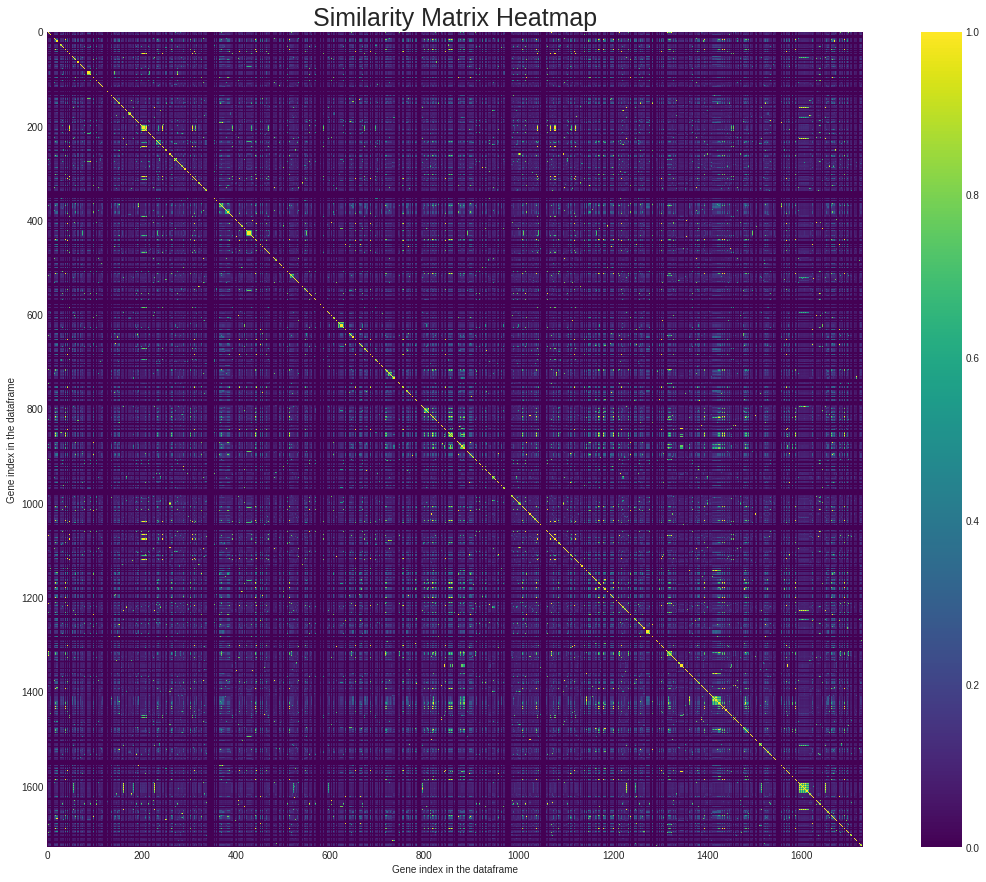

In [8]:
fig, ax = plt.subplots(figsize = (21,15))
im = ax.imshow(SimilarityMatrix, cmap='viridis')
plt.colorbar(im)
ax.set_title("Similarity Matrix Heatmap", fontsize = 25)
ax.set_ylabel("Gene index in the dataframe")
ax.set_xlabel("Gene index in the dataframe")
plt.savefig('../Imgs/SimilarityHeatMap.png')
plt.show()

# Machine learning
Hierarchical clustering is performed 

In [9]:
clustering = SpectralClustering(100,#int(round(PantherGeneList.shape[0]*0.10)), 
                                assign_labels = "kmeans", 
                               affinity = 'precomputed').fit(SimilarityMatrix)

df = pd.DataFrame(familySingletons, columns=["PANTHERfamily"])
df["Label"] = clustering.labels_

df.to_csv('../Data/ClusteredGenes.tsv', sep = '\t', index= False)

df.head()

/home/ideapad/anaconda3/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


PANTHERfamily  Label
0                         ABHYDROLASE      3
1                ABSCISIC HYDROXYLASE      3
2                ABSCISIC INSENSITIVE      3
3                   ABSCISIC RECEPTOR     45
4  ACETYL ACETYLTRANSFERASE CYTOSOLIC     37

## Plot the number of elements in each cluster

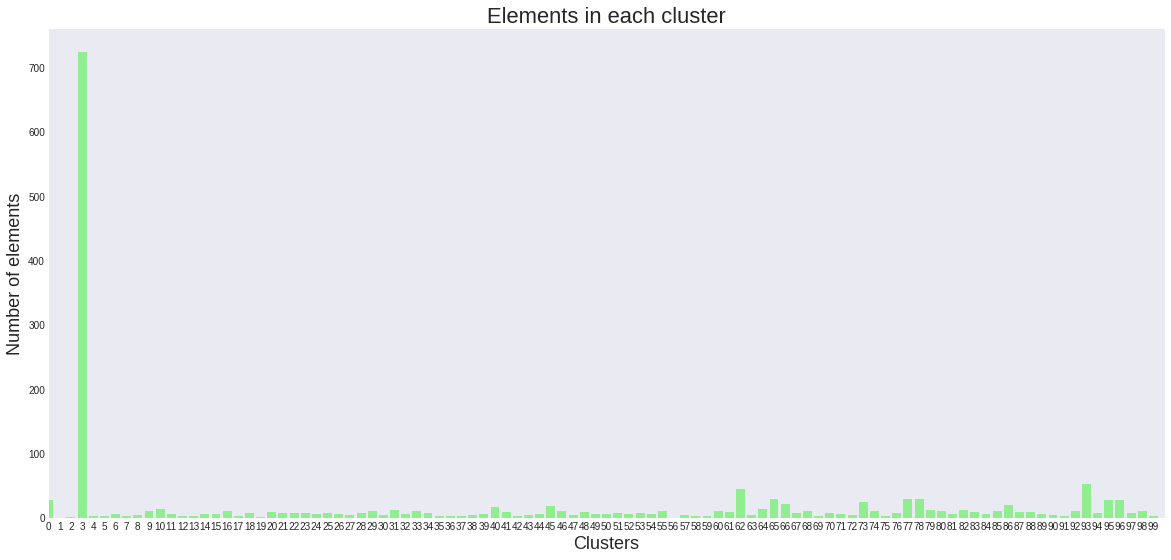

In [10]:
fig, ax = plt.subplots(figsize = (20,9))
for i,j in df.groupby('Label'):
    ax.bar(i,j.count(), color = 'lightgreen')

ax.set_xlim((0,100))
vals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(int(x)) for x in vals])

ax.set_xlabel('Clusters', fontsize = 18)
ax.set_ylabel('Number of elements', fontsize = 18)
ax.set_title('Elements in each cluster', fontsize = 22)
ax.xaxis.set(ticks = range(100), ticklabels= range(100))

plt.savefig('../Imgs/ElementsInEachCluster.png')
plt.show()

Merging the dataframe of clusters with the original "PantherFamily" one. 

In [11]:
Labels = []

counterI, counterJ = 0, 0
for i in PantherGeneList['PANTHERfamily']:
    j = df['PANTHERfamily'][counterJ]
    while j <= i and counterJ < len(df): 
        j = df['PANTHERfamily'][counterJ]
        if i == j: 
            Labels.append(df['Label'][counterJ])
            counterJ = len(df)
        counterJ += 1
    counterJ = 0

PantherGeneList['Label'] = Labels

## Cluster checking
Let's see what we have in the clusters and print all of them in a file.

In [12]:
file = open("../Data/ClusterFile.txt","w")
for i,j in df.groupby('Label'):
    file.write("\n\nCluster {}. Number of elements: {}\n".format(i, 
                                                                 len(set(' '.join(
                                                                     j['PANTHERfamily']
                                                                 ).split())))) 
    for element in ' '.join(j['PANTHERfamily']).split():
        file.write('{}, '.format(element))
file.close()
ClusterDict = {}

for i,j in df.groupby('Label'):
    ClusterDict[i] = j['PANTHERfamily']

# Mapping the clusters

In [13]:
Mapping = MF.mapping_function('../Data/licausi_df.csv', CheckRelation = True)
Vv_Label = MF.label_assignment(Mapping, PantherGeneList)

Relation type: many to many


## Loading Vitis Dataset

In [14]:
VitisPantherGeneList = PantherGeneList = pd.read_csv('../Data/Gene_lists/Vv_pantherGeneList.txt', 
                             sep = '\t', 
                             index_col= False, 
                             names = ['GeneID', 
                                      'MappedID', 
                                      'Gene Name', 
                                      'PANTHERfamily', 
                                      'ProteinClass', 
                                      'Species']
                             ).iloc[:,[1,3]].dropna()
VitisPantherGeneList['PANTHERfamily'] = VitisPantherGeneList['PANTHERfamily'].apply(lambda x: x.split(' (')[0])
VitisPantherGeneList['PANTHERfamily'] = VitisPantherGeneList['PANTHERfamily'].apply(CleanText).replace('', np.nan)

In [15]:
Vv_Label = pd.merge(VitisPantherGeneList, Vv_Label, how = 'inner', on = 'MappedID')

Vv_Label = Vv_Label[Vv_Label['Label'] != '']

## Dividing the dataset
The dataset is divided, the unkknown genes are placed in `Vv_trained` and the known genes are stored in `Vv_Test`.

In [16]:
SelectionVector = (Vv_Label['PANTHERfamily'] == 'SUBFAMILY NOT NAMED') | (Vv_Label['PANTHERfamily'].isna())

Vv_trained = Vv_Label[SelectionVector]
Vv_Test = Vv_Label[SelectionVector == False]

Each `PANTHERfamily` in the Test dataframe is compared to each one in the relative cluster, the mean similarity is calculated and then is plotted in order to see if the method is accurate.

In [17]:
IndexList = list(Vv_Test[Vv_Test.columns[0]].index)
IndexList
Affinity = np.zeros(Vv_Test.shape[0])
Vv_Test['Affinity'] = pd.Series(Affinity, index=IndexList)
# ========================================================
def AffCalculation(PANTHERfamily, Labels, ClusterDict):
    """
    This function returns how much a given family is similar
    to a cluster"""
    
    def Similarity(PANTHERfamily, label, ClusterDict):
        Affinity = []

        for element in ClusterDict[label]:
            Affinity.append(sentence_similarity(PANTHERfamily, element))
    
        return sum(Affinity)/len(Affinity)
    
    if isinstance(Labels, str):
        Labels = Labels.split()
        
        temp = []
        for label in Labels:
            temp.append(Similarity(PANTHERfamily, int(label), ClusterDict))
        return sum(temp)/len(temp)
    else:
        return Similarity(PANTHERfamily, Labels, ClusterDict)

/home/ideapad/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [18]:
for element in IndexList:
    Vv_Test['Affinity'].loc[element] = AffCalculation(
        Vv_Test['PANTHERfamily'].loc[element], 
        Vv_Test['Label'].loc[element], 
        ClusterDict)

/home/ideapad/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ideapad/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


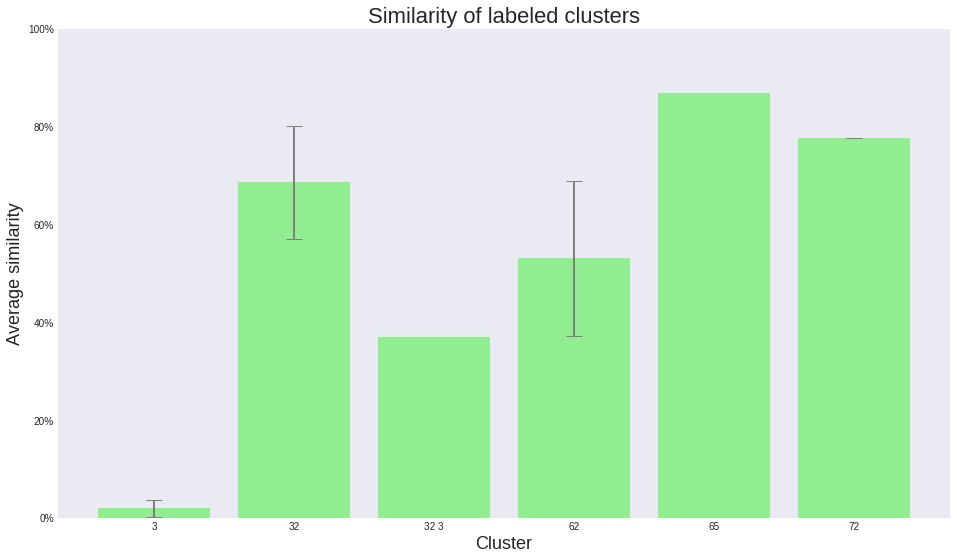

In [19]:
fig, ax = plt.subplots(figsize = (16,9))

for i,j in Vv_Test.groupby('Label'):
    ax.bar(i,
           j.mean(), 
           color = 'lightgreen',
          yerr = j.std(),
          error_kw = dict(
                          ecolor = 'grey',
                            elinewidth=2,
                            capsize = 8))

ax.set_ylim((0,1))
ax.set_xlabel('Cluster', fontsize = 18)
ax.set_ylabel('Average similarity', fontsize = 18)
ax.set_title('Similarity of labeled clusters', fontsize = 22)
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(int(x*100)) for x in vals])

plt.savefig('../Imgs/ClusterSimilarity.png')
plt.show()

In [20]:
file = open("Labelled_genes.txt","w")
for i,j in Vv_trained.groupby('Label'):
    file.write(">{}\n".format(i))
    for gene in j['MappedID']:
        file.write("{}\n".format(gene))
        
file.close()